# quant-econ Solutions: Continuous State Markov Chains

Solutions for http://quant-econ.net/jl/stationary_densities.html

In [18]:
using QuantEcon
using KernelDensity
using Distributions
using Plots
pyplot()
using StatPlots     # needed for box plot support

## Exercise 1


Look ahead estimation of a TAR stationary density, where the TAR model is

$$    X_{t+1} = \theta |X_t| + (1 - \theta^2)^{1/2} \xi_{t+1} $$

and $\xi_t \sim N(0,1)$.  Try running at n = 10, 100, 1000, 10000 to get an
idea of the speed of convergence.

[Plots.jl] Initializing backend: pyplot


2016-08-03 18:56:52.993 julia[99133:507] setCanCycle: is deprecated.  Please use setCollectionBehavior instead



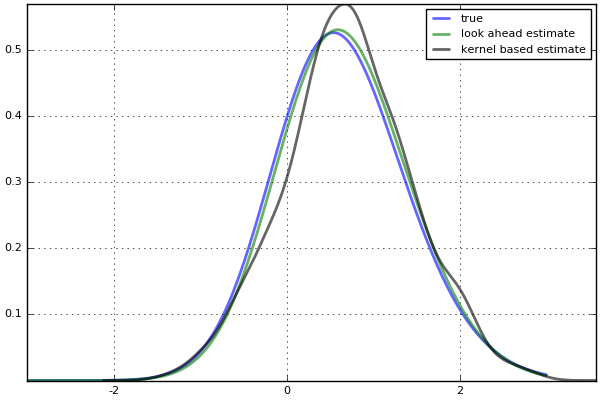

In [2]:
phi = Normal(0.0, 1.0)
n = 500
theta = 0.8
d = sqrt(1.0 - theta^2)
delta = theta / d
srand(41)  # reproducible results

# true density of TAR model
psi_star(y) = 2 .* pdf(phi, y) .* cdf(phi, delta * y)

# Stochastic kernel for the TAR model.
p(x, y) = pdf(phi, (y .- theta .* abs(x)) ./ d) ./ d

Z = rand(phi, n)
X = zeros(n)
for t=1:n-1
    X[t+1] = theta * abs(X[t]) + d * Z[t]
end

psi_est(a) = lae_est(LAE(p, X), a)
k_est = kde(X)

ys = linspace(-3, 3, 200)
plot(ys, psi_star(ys), color=:blue, lw=2, alpha=0.6, label="true")
plot!(ys, psi_est(ys), color=:green, lw=2, alpha=0.6, label="look ahead estimate")
plot!(k_est.x, k_est.density, color=:black, lw=2, alpha=0.6, label="kernel based estimate")

## Exercise 2

Here's one program that does the job.


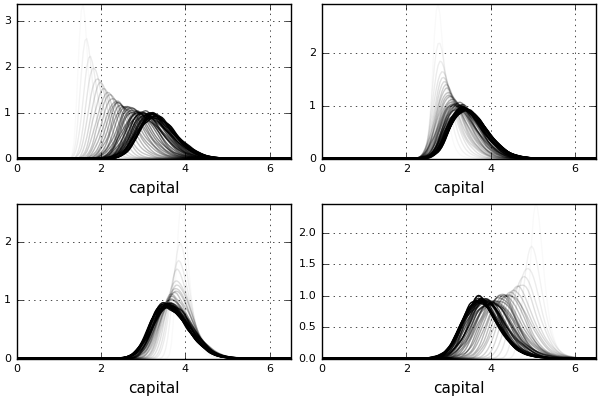

In [3]:
s = 0.2
delta = 0.1
a_sigma = 0.4  # A = exp(B) where B ~ N(0, a_sigma)
alpha = 0.4  # We set f(k) = k**alpha
psi_0 = Beta(5.0, 5.0)  # Initial distribution
phi = LogNormal(0.0, a_sigma)
srand(42)  # reproducible results


function p(x, y)
    #=
    Stochastic kernel for the growth model with Cobb-Douglas production.
    Both x and y must be strictly positive.
    =#
        d = s * x.^alpha

    # scipy silently evaluates the pdf of the lognormal dist at a negative
    # value as zero. It should be undefined and Julia recognizes this.
    pdf_arg = clamp((y .- (1-delta) .* x) ./ d, eps(), Inf)
    return pdf(phi, pdf_arg) ./ d
end


n = 1000  # Number of observations at each date t
T = 40  # Compute density of k_t at 1,...,T+1

xmax = 6.5
ygrid = linspace(0.01, xmax, 150)
laes_plot = zeros(length(ygrid), 4*T)
colors = []
for i=1:4
    k = Array(Float64, n, T)
    A = rand!(phi, Array(Float64, n, T))

    # Draw first column from initial distribution
    # match scale=0.5 and loc=2*i in python version
    k[:, 1] = (rand(psi_0, n) .+ 2.5i) ./ 2  
    for t=1:T-1
        k[:, t+1] = s*A[:, t] .* k[:, t].^alpha + (1-delta) .* k[:, t]
    end

    # Generate T instances of LAE using this data, one for each date t
    laes = [LAE(p, k[:, t]) for t=T:-1:1]
    ind = i
    for j = 1:T
        psi = laes[j]
        laes_plot[:, ind] = lae_est(psi, ygrid)
        ind = ind + 4
        push!(colors,  RGBA(0, 0, 0, 1 - (j - 1)/T))
    end
end

colors = reshape(reshape(colors, T, 4)', 4*T, 1)
plot(ygrid, laes_plot, layout=(2,2), color=colors', 
     legend=:none, xlabel="capital", xlims=(0, xmax))        

## Exercise 3

Here's a possible solution.

Note the way we use vectorized code to simulate the $k$ time series for one boxplot all at once.

In [4]:
n = 20
k = 5000
J = 6
srand(43)  # reproducible results

theta = 0.9
d = sqrt(1 - theta^2) 
delta = theta / d

initial_conditions = linspace(8, 0, J)

Z = randn(k, n, J)
titles = []
data = []
x_labels = []
for j=1:J
    title = "time series from t = $(initial_conditions[j])"
    push!(titles, title)
    
    X = Array(Float64, k, n)
    X[:, 1] = initial_conditions[j]
    labels = []
    labels = vcat(labels, ones(k, 1))
    for t=2:n
        X[:, t] = theta .* abs(X[:, t-1]) .+ d .* Z[:, t, j]
        labels = vcat(labels, t*ones(k, 1))
    end
    X = reshape(X, n*k, 1)
    push!(data, X)
    push!(x_labels, labels)
end



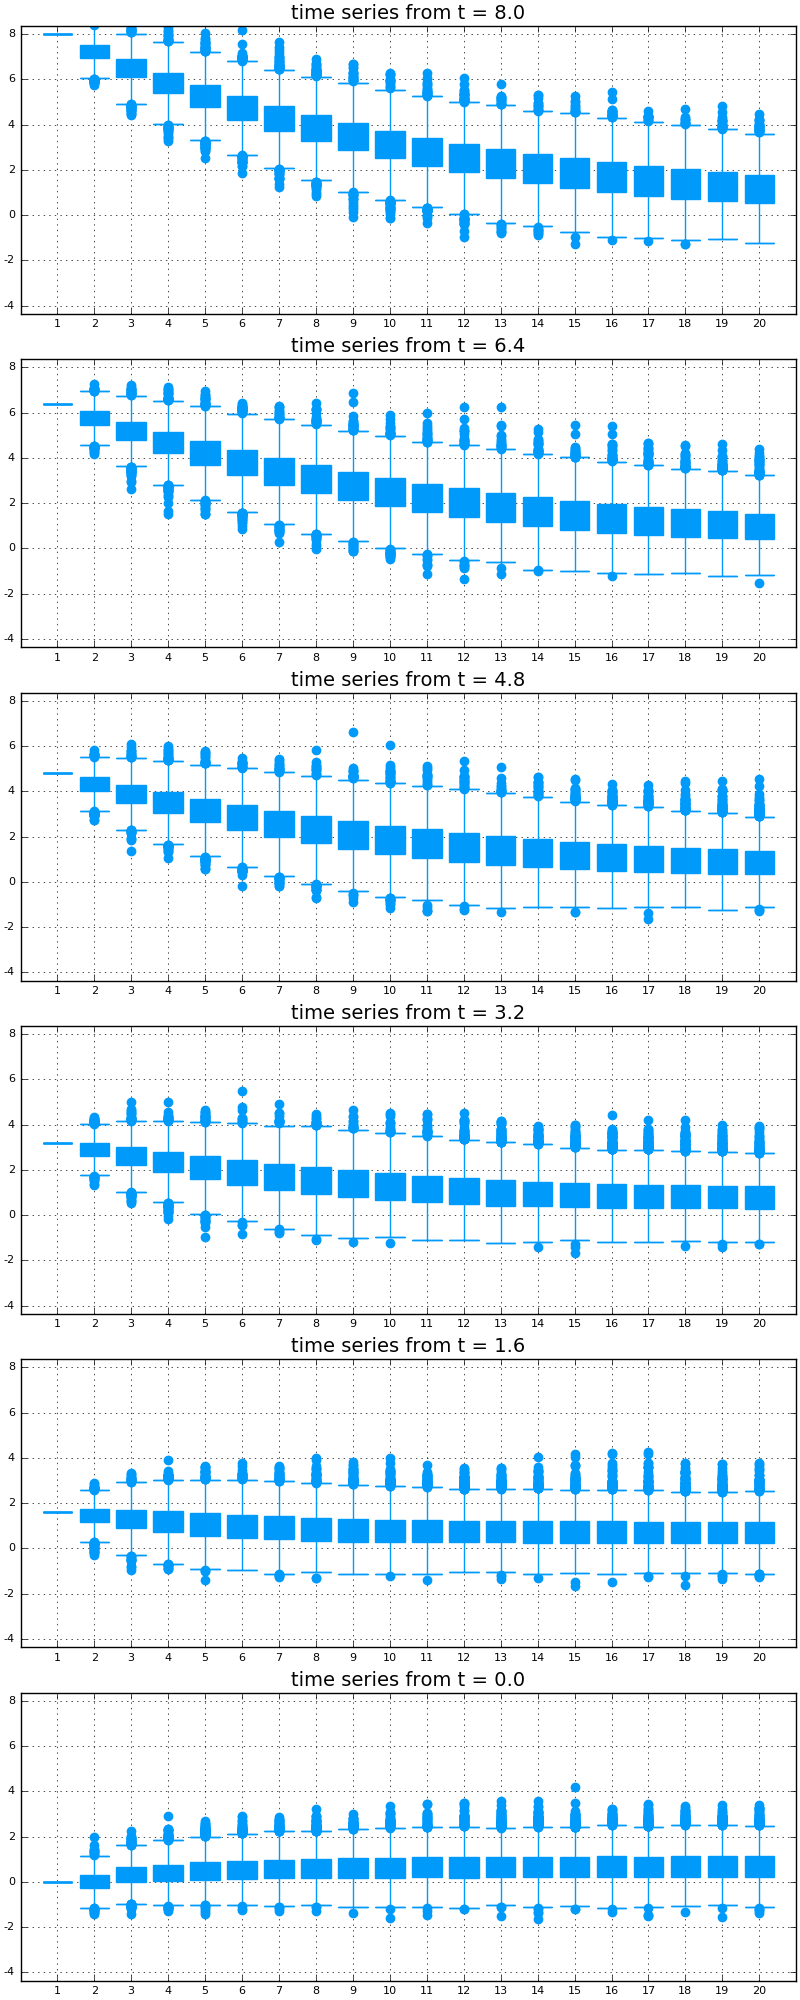

In [17]:
boxplot(x_labels, data, layout=(J,1), title=titles', ylims=(-4, 8), 
legend=:none, yticks=-4:2:8, xticks=1:20)
plot!(size=(800, 2000))